# Task Definition

* 주어진 데이터를 갖고 네트워크 칩입을 감지하는 Classfication Model을 설계하라.

* 주어진 데이터를 가공하고, 수정하여도 무관하다.

* 사용해 볼 수 있는 만큼 많은 모델을 시도하여 볼 것

* 사용한 모델은 모두 Jupyter Notebook에 남길 것 (채점할 때 실행 가능하도록)

* 보고서는 따로 워드로 제출할 것 (보고서 양식은 따로 없음)

# Data Description

해당 데이터는 KDD Cup 1999 Dataset을 가공한 네트워크 칩입 감지 시스템용 데이터이다. 각 Feature들은 어떤 protocol type을 사용하는 지 혹은 어떤 service를 사용하는 지 등의 내용를 담고 있다. Class는 현재 네트워크가 침입을 당한 상태인 지 만약 침입을 당하였다면 어떤 종류의 침입을 당했는 지를 나타낸다.

# Feature Description

## Total 41 Features.

duration: continuous.

protocol_type: symbolic.

service: Numeric, categorical

flag: Numeric, categorical

src_bytes: continuous.

dst_bytes: continuous.

land: symbolic.

wrong_fragment: continuous.

urgent: continuous.

hot: continuous.

num_failed_logins: continuous.

logged_in: symbolic.

num_compromised: continuous.

root_shell: continuous.

su_attempted: continuous.

num_root: continuous.

num_file_creations: continuous.

num_shells: continuous.

num_access_files: continuous.

num_outbound_cmds: continuous.

is_host_login: symbolic.

is_guest_login: symbolic.

count: continuous.

srv_count: continuous.

serror_rate: continuous.

srv_serror_rate: continuous.

rerror_rate: continuous.

srv_rerror_rate: continuous.

same_srv_rate: continuous.

diff_srv_rate: continuous.

srv_diff_host_rate: continuous.

dst_host_count: continuous.

dst_host_srv_count: continuous.

dst_host_same_srv_rate: continuous.

dst_host_diff_srv_rate: continuous.

dst_host_same_src_port_rate: continuous.

dst_host_srv_diff_host_rate: continuous.

dst_host_serror_rate: continuous.

dst_host_srv_serror_rate: continuous.

dst_host_rerror_rate: continuous.

dst_host_srv_rerror_rate: continuous.

보다 자세한 설명은 http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html 를 참조(가공된 데이터이기 때문에, 사이트와 다른 점이 있음을 염두할것.)

# Class Description

"Normal", "dos", "u2r", "r2l", "probe" 5개의 Class가 존재한다.

Normal은 정상을 의미하며, 나머지 4개는 네트워크상 침입 기법들의 이름들이다.

#### 본 레포트는 주어진 data를 통하여 네트워크상 침입 기법을 classify하는 방법에 대해서 논하였다.
#### 레포트는 먼저 
### Section 1에서 기본 데이터를 numerical로만 바꾸어 사전 실험을 해보았고, 
### Section 2에서는 Feature selection과 normalization을 통하여 Feature의 변화를 주었다. 
### Section 3에서는 변화된 Feature를 적용하여 model에 적용하였고, 
### Section 4에서는 다양한 model을 만들어 보았다.  
### Section 5에서는 전체적인 내용을 정리하였다.

# Section 1. 사전 TEST

## 1. Pandas로 데이터 불러오기

#### 제시해준 train data와 test data를 pandas로 불러왔다.

In [2]:
import pandas as pd
data = pd.read_csv('train_data.csv')

In [3]:
test_data = pd.read_csv('test_data.csv')
test_data=test_data.drop('Unnamed: 0',axis=1)

## 2. Numeric Feature로 바꾸기
#### protocol_type feature는 symbolic한 data 값을 가지므로 numeric feature로 바꾸어야 했다.
#### Label encoding과 one hot encoding을 이용하여 바꾸었다.
### (1) Label Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
le = LabelEncoder()

In [6]:
integer_encoded = le.fit_transform(data.iloc[:,1])

In [7]:
integer_encoded

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
data_label=data.apply(le.fit_transform)

In [9]:
integer_encoded_test = le.fit_transform(test_data.iloc[:,1])

In [10]:
test_data_label = test_data.apply(le.fit_transform)

### (2) One Hot Encoder

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
ohe = OneHotEncoder()

In [13]:
ohe.fit_transform(data_label.iloc[:,1].values.reshape(-1,1)).toarray()

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [14]:
protocol_type2 = pd.get_dummies(data.iloc[:,1])

In [15]:
data2=data.drop(data.iloc[:,1:],axis=1)

In [16]:
data_onehot=pd.concat([data2,protocol_type2],axis=1)

In [17]:
data2=data.drop(data.iloc[:,:2],axis=1)

In [18]:
data_onehot=pd.concat([data_onehot,data2],axis=1)

In [19]:
ohe.fit_transform(test_data_label.iloc[:,1].values.reshape(-1,1)).toarray()

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [20]:
test_protocol_type=pd.get_dummies(test_data.iloc[:,1])

In [21]:
test_data2=test_data.drop(test_data.iloc[:,1:],axis=1)
test_data_onehot=pd.concat([test_data2,test_protocol_type],axis=1)
test_data2=test_data.drop(test_data.iloc[:,:2],axis=1)
test_data_onehot=pd.concat([test_data_onehot,test_data2],axis=1)

## 2. Cross-Validation
### 1) Data Split
#### 가장 먼저 주어진 train data를 나누어 cross-validation으로 대략적인 model의 성능을 파악하였다.
#### Train data set을 train 전용 데이터와 test 전용 데이터로 분리하였으며 비율은 8:2이다.

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
x =(data_onehot.iloc[:,:-1])
y=(data_onehot.iloc[:,-1])

In [74]:
x_train_cv,x_test_cv,y_train_cv,y_test_cv = train_test_split(x,y,test_size=0.2,stratify=y)

### 2) K-Fold
#### Cross Validation을 확인하기 위하여 K-Fold기법을 사용하였다.
#### K 값으로는 10을 사용하였다.

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [76]:
kf=KFold(n_splits=10)

### 3) Model에 적용하기

#### (1) Decision Tree

In [2]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()

In [95]:
score=cross_val_score(decision_tree,x,y,cv=kf,n_jobs=-1)
score.mean()

0.9978169985135068

#### (2) Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

In [96]:
score=cross_val_score(LR,x,y,cv=kf,n_jobs=-1)
score.mean()

0.84628451780621494

#### (3) Perceptron

In [4]:
from sklearn.linear_model import Perceptron
Perceptron = Perceptron()

In [97]:
score=cross_val_score(Perceptron,x,y,cv=kf,n_jobs=-1)
score.mean()

0.21631745150882051

#### (4) MLP(Multi Layered Perceptron)

In [5]:
from sklearn.neural_network import MLPClassifier
MLP_classifier = MLPClassifier(hidden_layer_sizes=(20,6), max_iter=100, warm_start=True)

In [98]:
score=cross_val_score(MLP_classifier,x,y,cv=kf,n_jobs=-1)
score.mean()

0.94744887688681412

#### (5) KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
KNN=KNeighborsClassifier()

In [99]:
score=cross_val_score(KNN,x,y,cv=kf,n_jobs=-1)
score.mean()

0.99251427717546226

#### (6) SVM

In [7]:
from sklearn import svm
SVM=svm.SVC(kernel='linear')

In [ ]:
score=cross_val_score(SVM,x,y,cv=kf,n_jobs=-1)
score.mean()

#### (7) Ensemble
##### (7)-1 Bagging Classifier
##### Estimator로 Decision Tree로 사용하였다.

In [8]:
from sklearn.ensemble import BaggingClassifier
bagging=BaggingClassifier(tree.DecisionTreeClassifier())

In [100]:
score=cross_val_score(bagging,x,y,cv=kf,n_jobs=-1)
score.mean()

0.99828534635366706

#### (7)-2 AdaBoost

In [9]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=100)

In [101]:
score=cross_val_score(adaboost,x,y,cv=kf,n_jobs=-1)
score.mean()

0.82362013685374758

#### (7)-3 Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10)

In [104]:
score=cross_val_score(random_forest,x,y,cv=kf,n_jobs=-1)
score.mean()

0.9986743240764101

### 4) 결과 정리

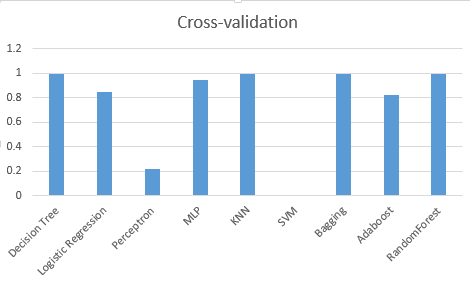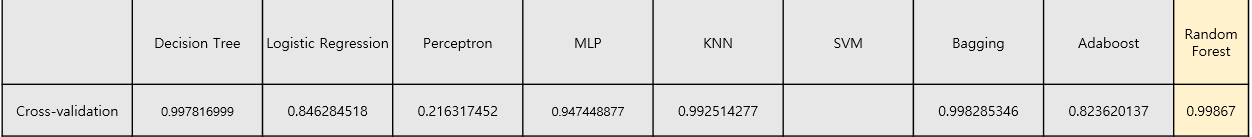
#### Decision tree, Logistic regression, perceptron, MLP, KNN, Bagging, Adaboos, Random Forest 알고리즘에 대해서 실험을 진행하였다.
#### Random Forest가 가장 좋은 결과를 나타내었다.

#### 또한 Stratified Cross Validation을 한 결과, 수업시간에 배운 대로, Variation이 작은 것을 확인할 수 있었다.

## 3. 주어진 Test Data와 Train Data로 나누기

In [24]:
x_train =(data_onehot.iloc[:,:-1])
y_train=(data_onehot.iloc[:,-1])

In [25]:
x_test =(test_data_onehot.iloc[:,:-1])
y_test=(test_data_onehot.iloc[:,-1])

## 4. Model에 적용하기

### 1) Decision Tree
#### 불러오기

In [26]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()

#### 학습시키기

In [71]:
decision_tree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### 평가하기

In [72]:
decision_tree.score(x_test,y_test)

0.75460000000000005

### 2) Logistic Regression
#### 불러오기

In [27]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

#### 학습시키기

In [28]:
LR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 평가하기

In [29]:
LR.score(x_test,y_test)

0.61480000000000001

### 3) Perceptron
#### 불러오기

In [28]:
from sklearn.linear_model import Perceptron

In [29]:
Perceptron = Perceptron()

#### 학습시키기

In [32]:
Perceptron.fit(x_train,y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

#### 평가하기

In [33]:
Perceptron.score(x_test,y_test)

0.1191

### 4) MLP(Multi Layerd Perceptron
#### 불러오기

In [66]:
from sklearn.neural_network import MLPClassifier

In [67]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(20,6), max_iter=100, warm_start=True)

#### 학습시키기

In [61]:
MLP_classifier.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 6), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

#### 평가하기

In [76]:
MLP_classifier.score(x_test,y_test)

0.74319999999999997

### 5) KNN
#### 불러오기

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
KNN=KNeighborsClassifier()

#### 학습시키기

In [40]:
KNN.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### 평가하기

In [41]:
KNN.score(x_test,y_test)

0.73540000000000005

### 6) SVM
#### 불러오기

In [34]:
from sklearn import svm

In [35]:
SVM=svm.SVC(kernel='linear')

#### Sample Data 뽑기

In [36]:
data_sample = data_onehot.sample(10000)

In [37]:
x_sample = data_sample.iloc[:,:-1]
y_sample = data_sample.iloc[:,-1]

#### 학습시키기

In [ ]:
SVM.fit(x_sample,y_sample)

### 평가하기

In [ ]:
SVM.score(x_test,y_test)

### 7)Ensemble
#### (1) Bagging Classifier
#### 불러오기

In [38]:
from sklearn.ensemble import BaggingClassifier

In [39]:
from sklearn import tree

In [40]:
bagging=BaggingClassifier(tree.DecisionTreeClassifier())

#### 학습하기

In [45]:
bagging.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

#### 평가하기

In [46]:
bagging.score(x_test,y_test)

0.76219999999999999

#### (2) AdaBoost
#### 불러오기

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### 학습하기

In [42]:
adaboost = AdaBoostClassifier(n_estimators=100)

In [49]:
adaboost = adaboost.fit(x_train, y_train)

#### 평가하기

In [50]:
adaboost.score(x_test,y_test)

0.65810000000000002

#### (3) Random Forest
#### 불러오기

In [43]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10,bootstrap=False,criterion='gini')

#### 학습하기

In [54]:
random_forest = random_forest.fit(x_train, y_train)

#### 평가하기

In [55]:
random_forest.score(x_test, y_test)

0.75609999999999999

### 8) 결과정리

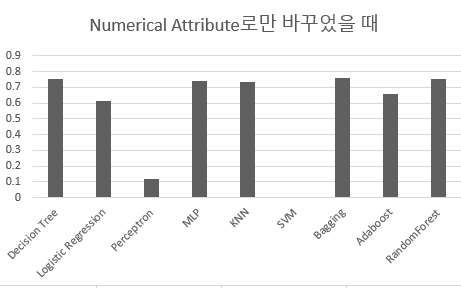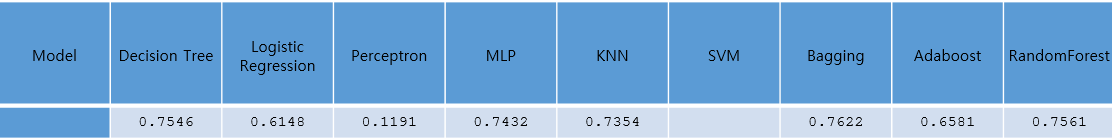
#### Decision tree, MLP, KNN, Bagging,RandomForest에 대해서 좋은 성능을 보였다.

#### 그 중 Random Forest 에 대해서 가장 좋은 성능을 나타내는 것을 볼 수 있었다.

# Section 2.Features
#### (가장 성능이 우수하였던 Random Forest를 이용하였다.)

## 1. Data Check

In [126]:
data_onehot.describe()

,duration,icmp,tcp,udp,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,0.815167,0.065816,0.119018,32.086288,2.575179,4.556674e+04,1.977911e+04,0.000198,0.022687,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,0.388164,0.247961,0.323810,16.462574,1.141552,5.870331e+06,4.021269e+06,0.014086,0.253530,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,0.000000,0.000000,20.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,1.000000,0.000000,0.000000,25.000000,2.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1.000000,0.000000,0.000000,50.000000,4.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.000000,1.000000,1.000000,70.000000,11.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 각 Feature들의 속성은 위의 표와 같다.
#### 총 43개의 Feature들을 가지고 있다.

In [41]:
data_onehot.columns

Index(['duration', 'icmp', 'tcp', 'udp', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'xAttack'],
      dtype='object')

## 2. Feature Selection

### 1) 직관적인 Feature Selection
#### 직관적으로 Feature를 분석하여 Feature Selection을 실행하여 보았다.

In [58]:
data_onehot.is_host_login.describe()

count    125973.000000
mean          0.000008
std           0.002817
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_host_login, dtype: float64

In [127]:
data_onehot.land.describe()

count    125973.000000
mean          0.000198
std           0.014086
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: land, dtype: float64

#### (1) is_host_login feature,land는 variance가 매우 낮다. -> 따라서 feature를 제거해도 무방하다.
##### Variance가 매우 낮은 Feature들은 제거해도 무방하다고 판단하였다. 수업시간에 배운 PCA 개념에서 아이디어를 착안한 것이다.

In [44]:
data_onehot1=data_onehot.drop('is_host_login',axis=1)
test_data_onehot1=test_data_onehot.drop('is_host_login',axis=1)
data_onehot1=data_onehot1.drop('land',axis=1)
test_data_onehot1=test_data_onehot1.drop('land',axis=1)

In [60]:
x_train =(data_onehot1.iloc[:,:-1])
y_train=(data_onehot1.iloc[:,-1])
x_test =(test_data_onehot1.iloc[:,:-1])
y_test=(test_data_onehot1.iloc[:,-1])

In [281]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.75970000000000004

### 75.61%의 정확도에서 75.97%의 정확도로 향상되었다.



#### (2) num_failed_logins는 class와 큰 관련성이 없어 보였다.
##### Feature value의 크기와 Class를 비교하였을 때, 큰 관련성이 없어보여 Feature를 제거하여 보았다.

In [45]:
data_onehot2=data_onehot1.drop('num_failed_logins',axis=1)
test_data_onehot2=test_data_onehot1.drop('num_failed_logins',axis=1)

In [63]:
x_train =(data_onehot2.iloc[:,:-1])
y_train=(data_onehot2.iloc[:,-1])
x_test =(test_data_onehot2.iloc[:,:-1])
y_test=(test_data_onehot2.iloc[:,-1])

In [277]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.76119999999999999

### 75.97%의 정확도에서 76.11%의 정확도로 향상되었다.

#### 2) urgent는 class와 큰 관련성이 없어 보였다.
##### 마찬가지로 urgent feature도 class와 연관이 많이 없어 보여 해당 feature를 제거하여 보았다.

In [52]:
data_onehot3=data_onehot1.drop('urgent',axis=1)
test_data_onehot3=test_data_onehot1.drop('urgent',axis=1)
x_train =(data_onehot3.iloc[:,:-1])
y_train=(data_onehot3.iloc[:,-1])
x_test =(test_data_onehot3.iloc[:,:-1])
y_test=(test_data_onehot3.iloc[:,-1])

In [51]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.76339999999999997

### 75.97%의 정확도에서 76.34%의 정확도로 향상되었다.

#### 3) urgent,num-failed-logins를 모두 빼보았다.
##### 앞서 class와 많은 상관이 없어 보였던 Feature를 제거하고 실험하여 보았다.

In [53]:
data_onehot4=data_onehot2.drop('urgent',axis=1)
test_data_onehot4=test_data_onehot2.drop('urgent',axis=1)
x_train =(data_onehot4.iloc[:,:-1])
y_train=(data_onehot4.iloc[:,-1])
x_test =(test_data_onehot4.iloc[:,:-1])
y_test=(test_data_onehot4.iloc[:,-1])

In [303]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.76839999999999997

### 76.83%의 정확도로 향상되었다.

## 결과적으로 Classification에 큰 영향을 미치지 않는 Feature를 제거하였을 때에는,
## 전반적으로 성능이 향상되는 결과를 볼 수 있었다.

#### 4) service와 같은 attribute는 '어떤 service가 어떤 공격에 취약하다.'와 같은 것을 나타내는 듯 했다.
##### 나의 직관적인 판단이 맞는 지 확인하고자, classification에 영향을 많이 미치는 듯한 Feature를 제거하고 실험하였을 때의 결과를 보고자 하였다.

In [54]:
data_onehot5=data_onehot1.drop('service',axis=1)
test_data_onehot5=test_data_onehot1.drop('service',axis=1)
x_train =(data_onehot5.iloc[:,:-1])
y_train=(data_onehot5.iloc[:,-1])
x_test =(test_data_onehot5.iloc[:,:-1])
y_test=(test_data_onehot5.iloc[:,-1])

In [305]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.75239999999999996

### 75.23%의 정확도로 하향되었다. 
### 즉, service attribute는 결과값에 긍정적인 영향을 주는 attribute인것을 볼 수 있었으며,
## Classification에 긍정적인 영향을 미치는 Attribute를 삭제할 경우 성능이 떨어질 수 있음을 확인하였다.

## 2) Weka를 이용한 feature selection
#### Data를 Sampling하여 weka에서 지원하는 feature selection을 이용하여 보았다.
#### 비록 sampling한 data 크기로 인하여 100% 신뢰할 수는 없지만, Tool 자체는 믿을만한 결과를 가져 올 수 있을 것이라고 생각하였다.
###  (1) Subset evaluate
#### Subset evaluate를 실행하였다. Wrapper방식을 이용하였는 데, Data의 크기를 매우 크게 할 경우 시간이 매우 많이 소모되었다.
#### 따라서, 5000개의 Data만을 sampling하여 사용하였다.

In [309]:
data_sample=data_onehot.sample(5000)
data_sample.to_csv('out1.csv')

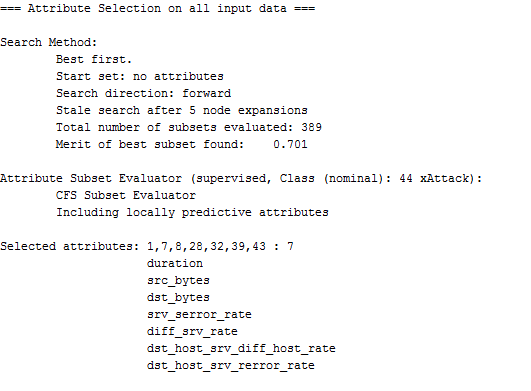

#### Wrapper의 결과는 다음과 같았다.
#### Wrapper를 사용할 때에는 Search Direction은 Forward 방식을 사용하였고, Estimator는 Random Forest를 사용하였다.

In [55]:
data_select=data_onehot.drop(data_onehot.iloc[:,1:6],axis=1)
test_data_select=test_data_onehot.drop(test_data_onehot.iloc[:,1:6],axis=1)

In [56]:
data_select=data_select.drop(data_select.iloc[:,3:22],axis=1)
test_data_select=test_data_select.drop(test_data_select.iloc[:,3:22],axis=1)

In [57]:
data_select=data_select.drop(data_select.iloc[:,4:7],axis=1)
test_data_select=test_data_select.drop(test_data_select.iloc[:,4:7],axis=1)

In [58]:
data_select=data_select.drop(data_select.iloc[:,5:11],axis=1)
test_data_select=test_data_select.drop(test_data_select.iloc[:,5:11],axis=1)

In [59]:
data_select=data_select.drop(data_select.iloc[:,6:8],axis=1)
test_data_select=test_data_select.drop(test_data_select.iloc[:,6:8],axis=1)

In [60]:
data_select=data_select.drop(data_select.iloc[:,7:7],axis=1)
test_data_select=test_data_select.drop(test_data_select.iloc[:,7:7],axis=1)

In [307]:
x_trains =(data_select.iloc[:,:-1])
y_trains=(data_select.iloc[:,-1])
x_tests =(test_data_select.iloc[:,:-1])
y_tests=(test_data_select.iloc[:,-1])
random_forest.fit(x_trains,y_trains)
random_forest.score(x_tests,y_tests)

0.75260000000000005

### 정확도가 떨어지는 결과를 가지고 왔다.
#### 그 이유는 Sample 된 데이터가 충분치 않았기 때문인 것으로 파악된다.
#### 이번 시도를 통하여 Wrapper 방식이 시간 복잡도가 매우 큰 알고리즘이라는 것을 실전적으로 확인할 수 있었다.

### (2) Filtering
#### Filtering 방식은 Time Complexity가 작기 때문에, 좀더 많은 Data를 활용할 수 있었고, 결과를 바로 받아 볼 수 있었다.
#### 전체 Train data 중 약 1/12에 해당하는 10000개의 sampled data에 대해서 실험을 Filtering을 진행하였다.
#### OneR, InfoGain 등 다양한 기준으로 Filtering을 진행하였다.

In [128]:
data_sample=data_onehot.sample(10000)
data_sample.to_csv('out1.csv')

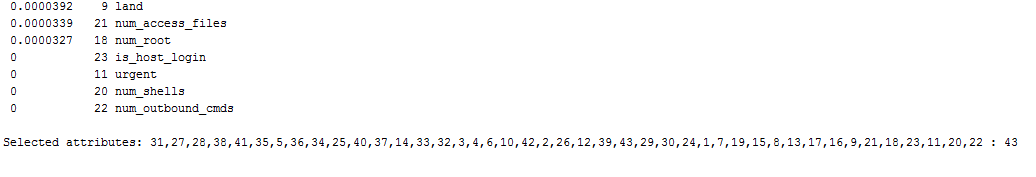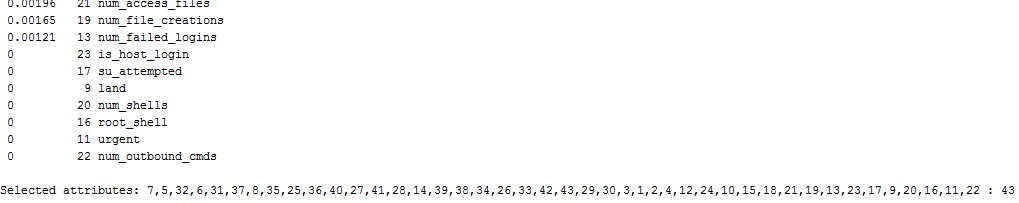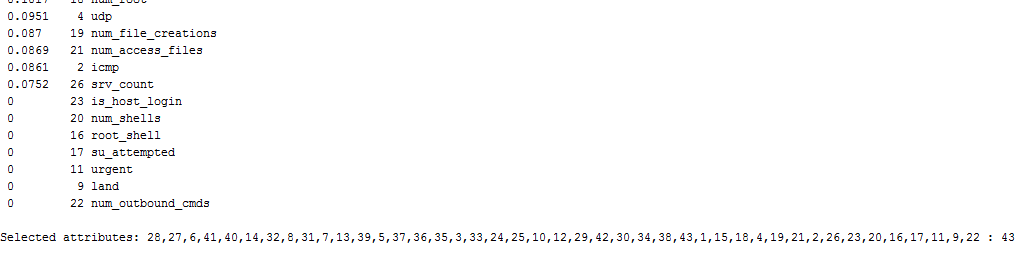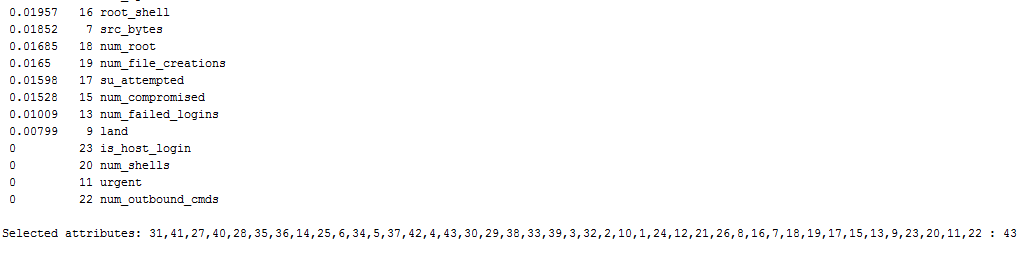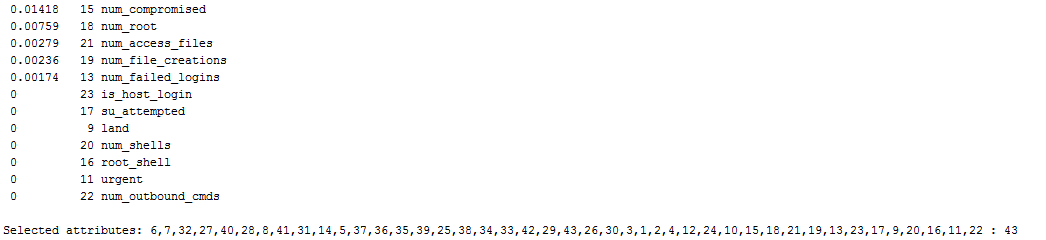
### 가장 공통적으로 urgent, is_host_login,num_shells,num_outbound_cmds가 가장 irrelevent한 feature인 것을 확인 하였다.

In [61]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)

In [62]:
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])

In [661]:
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.76619999999999999

## 75.97%의 정확도에서 76.62%의 정확도로 향상되었다.

### cf 위에서 평가한 land와 num_failed_logins도 제거하여 보았다.

In [63]:
data_weka2=data_weka.drop('num_failed_logins',axis=1)
test_data_weka2=test_data_weka.drop('num_failed_logins',axis=1)

In [166]:
x_trainw2 =(data_weka2.iloc[:,:-1])
y_trainw2=(data_weka2.iloc[:,-1])
x_testw2 =(test_data_weka2.iloc[:,:-1])
y_testw2=(test_data_weka2.iloc[:,-1])
random_forest.fit(x_trainw2,y_trainw2)
random_forest.score(x_testw2,y_testw2)

0.74819999999999998

### 결과가 떨어지는 것을 볼 수 있었다.
## 직관적인 경우와 Tool(Weka)을 이용할 경우에 대해서 모두 평가하여 보았다.
## 가장 성능이 좋은 경우는 Tool을 이용했을 때였다.

## 3. Normalization - MinMax Normalization
#### Normalization은 Data의 상대적인 크기를 비교할 때 유용하게 사용할 수 있는 기법이다. 
#### 따라서 Data의 상대적인 크기가 아닌, 다른 요소가 중요할 경우에는 Normalization을 할 경우 성능이 떨어 질 수 있다.
#### 따라서 outlier data가 존재하는 경우와 데이터의 상대적인 크기가 매우 작은 경우에 대해서 Normalization을 적용하였다.

In [732]:
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.77549999999999997

### 1) Outlier Data가 존재한는 경우
#### Outlier Data가 존재하는 경우에는 상대적인 크기를 비교하기 위하여 Normalization을 사용하는 것이 좋다.
#### Duration과 src_byte, dst_byte는 outlier한 data가 존재가 확연히 드러나므로 Normalization을 실행해보았다.

In [65]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,0]=(data_weka.iloc[:,0]-data_weka.iloc[:,0].min())/(data_weka.iloc[:,0].max()-data_weka.iloc[:,0].min())
test_data_weka.iloc[:,0]=(test_data_weka.iloc[:,0]-test_data_weka.iloc[:,0].min())/(test_data_weka.iloc[:,0].max()-test_data_weka.iloc[:,0].min())

In [734]:
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.74339999999999995

In [66]:
data_weka.iloc[:,6:8]=(data_weka.iloc[:,6:8]-data_weka.iloc[:,6:8].min())/(data_weka.iloc[:,6:8].max()-data_weka.iloc[:,6:8].min())
test_data_weka.iloc[:,6:8]=(test_data_weka.iloc[:,6:8]-test_data_weka.iloc[:,6:8].min())/(test_data_weka.iloc[:,6:8].max()-test_data_weka.iloc[:,6:8].min())

In [736]:
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.73080000000000001

#### 전반적으로 결과가 떨어지는 모습을 보였다.
#### Duration feature와 같은 경우에는 데이터의 상대적인 크기보다는 영역이 중요하였기 때문이다.
#### src_data와 dst_data와 같은 경우에는 특정 값 이상의 경우 대부분이 normal class로 분류되는 것을 볼 수 있었다. 그렇기 때문에 normalization이 오히려 성능을 저하시키는 것으로 분석되었다.

### 2) 데이터의 크기가 매우 작을 경우
#### 데이터의 상대적인 크기를 비교해야 되나 데이터의 크기가 매우 작으면 그 차이가 미미하여 학습이 제대로 되지 않는다.
#### 따라서 그러한 데이터에 대해서는 normalization이 필요하다.
#### srv_count, serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate는 그러한 경우에 해당하는 feature들이기 때문에  Normalization을 실행하여 보았다.
#### 먼저 각각에 대해서 실험을 진행하고, 모든 feature를 normalization하고 실험을 진행하였다.

### (1) srv_count

In [737]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,22]=(data_weka.iloc[:,22]-data_weka.iloc[:,22].min())/(data_weka.iloc[:,22].max()-data_weka.iloc[:,22].min())
test_data_weka.iloc[:,22]=(test_data_weka.iloc[:,22]-test_data_weka.iloc[:,22].min())/(test_data_weka.iloc[:,22].max()-test_data_weka.iloc[:,22].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.76170000000000004

### (2) serror_rate

In [738]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,23]=(data_weka.iloc[:,23]-data_weka.iloc[:,23].min())/(data_weka.iloc[:,23].max()-data_weka.iloc[:,23].min())
test_data_weka.iloc[:,23]=(test_data_weka.iloc[:,23]-test_data_weka.iloc[:,23].min())/(test_data_weka.iloc[:,23].max()-test_data_weka.iloc[:,23].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.77769999999999995

### (3) service_serror_rate

In [739]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,24]=(data_weka.iloc[:,24]-data_weka.iloc[:,24].min())/(data_weka.iloc[:,24].max()-data_weka.iloc[:,24].min())
test_data_weka.iloc[:,24]=(test_data_weka.iloc[:,24]-test_data_weka.iloc[:,24].min())/(test_data_weka.iloc[:,24].max()-test_data_weka.iloc[:,24].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.75470000000000004

### (4) rerror_rate

In [740]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,25]=(data_weka.iloc[:,25]-data_weka.iloc[:,25].min())/(data_weka.iloc[:,25].max()-data_weka.iloc[:,25].min())
test_data_weka.iloc[:,25]=(test_data_weka.iloc[:,25]-test_data_weka.iloc[:,25].min())/(test_data_weka.iloc[:,25].max()-test_data_weka.iloc[:,25].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.76190000000000002

### (5) srv_rerror_rate

In [741]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,26]=(data_weka.iloc[:,26]-data_weka.iloc[:,26].min())/(data_weka.iloc[:,26].max()-data_weka.iloc[:,26].min())
test_data_weka.iloc[:,26]=(test_data_weka.iloc[:,26]-test_data_weka.iloc[:,26].min())/(test_data_weka.iloc[:,26].max()-test_data_weka.iloc[:,26].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.75849999999999995

### (6) same_srv_rate

In [742]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,27]=(data_weka.iloc[:,27]-data_weka.iloc[:,27].min())/(data_weka.iloc[:,27].max()-data_weka.iloc[:,27].min())
test_data_weka.iloc[:,27]=(test_data_weka.iloc[:,27]-test_data_weka.iloc[:,27].min())/(test_data_weka.iloc[:,27].max()-test_data_weka.iloc[:,27].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.76000000000000001

### (7) diff_srv_rate

In [743]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,28]=(data_weka.iloc[:,28]-data_weka.iloc[:,28].min())/(data_weka.iloc[:,28].max()-data_weka.iloc[:,28].min())
test_data_weka.iloc[:,28]=(test_data_weka.iloc[:,28]-test_data_weka.iloc[:,28].min())/(test_data_weka.iloc[:,28].max()-test_data_weka.iloc[:,28].min())
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.76380000000000003

### (8) srv_count ~ diff_srv_rate 

In [744]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,22:29]=(data_weka.iloc[:,22:29]-data_weka.iloc[:,22:29].min())/(data_weka.iloc[:,22:29].max()-data_weka.iloc[:,22:29].min())
test_data_weka.iloc[:,22:29]=(test_data_weka.iloc[:,22:29]-test_data_weka.iloc[:,22:29].min())/(test_data_weka.iloc[:,22:29].max()-test_data_weka.iloc[:,22:29].min())

In [745]:
x_trainw =(data_weka.iloc[:,:-1])
y_trainw=(data_weka.iloc[:,-1])
x_testw =(test_data_weka.iloc[:,:-1])
y_testw=(test_data_weka.iloc[:,-1])
random_forest.fit(x_trainw,y_trainw)
random_forest.score(x_testw,y_testw)

0.75039999999999996

## 3) 결과 정리

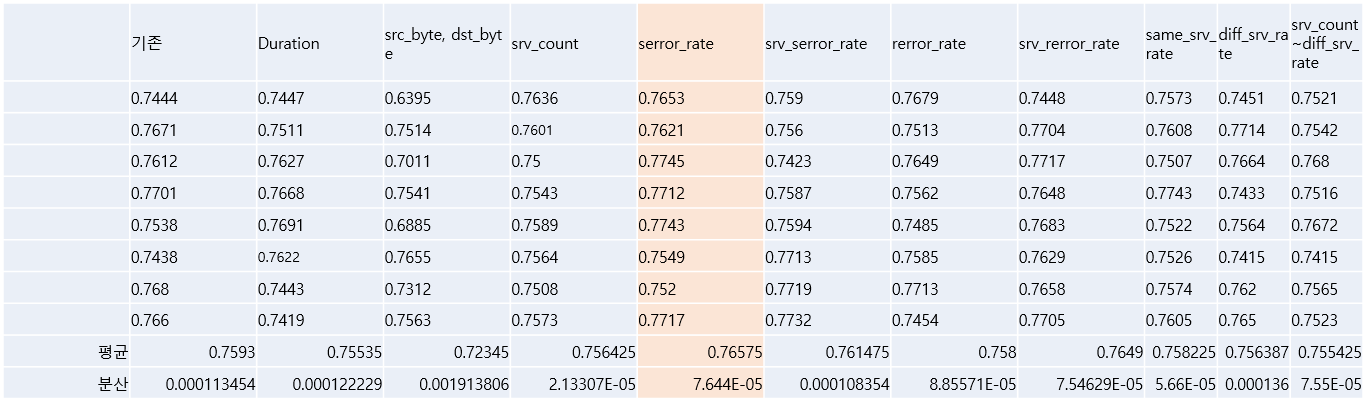
#### 8번의 iteration 결과 serror_rate feature를 normalization 시켰을 때, 가장 좋은 성능을 보였다.
#### 여러가지 feature를 normalization 시켰을 때는 오히려 성능이 저하 되었다.

## 4. 결과
### 1) urgent, is_host_login,num_shells,num_outbound_cmds와 같은  irrelevent한 feature를 제거하고
### 2) serror_rate를 normalization한 dataset을 사용하였다.

In [33]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)
test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)
data_weka.iloc[:,23]=(data_weka.iloc[:,23]-data_weka.iloc[:,23].min())/(data_weka.iloc[:,23].max()-data_weka.iloc[:,23].min())
test_data_weka.iloc[:,23]=(test_data_weka.iloc[:,23]-test_data_weka.iloc[:,23].min())/(test_data_weka.iloc[:,23].max()-test_data_weka.iloc[:,23].min())

data_final=data_weka
test_data_final = test_data_weka

x_train =(data_final.iloc[:,:-1])
y_train=(data_final.iloc[:,-1])
x_test =(test_data_final.iloc[:,:-1])
y_test=(test_data_final.iloc[:,-1])

# Section 3. 기본적인 알고리즘 모델에 적용

In [146]:
!pip install sklearn_evaluation

In [171]:
from sklearn_evaluation import plot
from sklearn.model_selection import learning_curve, validation_curve

In [172]:
%matplotlib inline

## 1. Decision Tree

In [749]:
decision_tree.fit(x_train,y_train)
decision_tree.score(x_test,y_test)

0.76259999999999994

### Prediction

In [47]:
sam= test_data_final.sample(1)
sam.xAttack

3711    normal
Name: xAttack, dtype: object

In [48]:
sam = sam.iloc[:,:-1]
decision_tree.predict(sam)

array(['normal'], dtype=object)

#### Prediction Success!!!
### Graphs

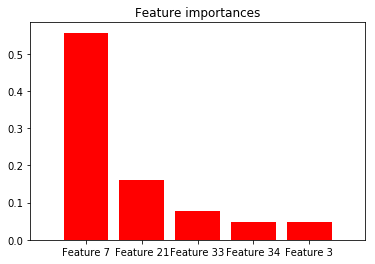

In [163]:
plot.feature_importances(decision_tree,top_n=5)

#### dst_bytes가 가장 중요한 feature로 나타났다.

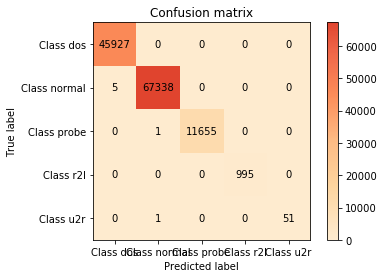

In [168]:
plot.confusion_matrix(data_final.iloc[:,-1], decision_tree.predict(data_final.iloc[:,:-1]))

#### Normal Class에 대해서 가장 정확히 분류해내는 모습을 보여준다.

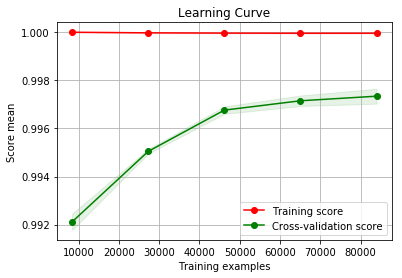

In [174]:
train_sizes, train_scores, test_scores = learning_curve(decision_tree, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 성능이 향상 되었다.

## 2. Logistic Regression

In [777]:
LR.fit(x_train,y_train)
LR.score(x_test,y_test)

0.61419999999999997

In [50]:
LR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Prediction

In [51]:
sam= test_data_final.sample(1)
sam.xAttack

1732    dos
Name: xAttack, dtype: object

In [52]:
sam = sam.iloc[:,:-1]
LR.predict(sam)

array(['dos'], dtype=object)

#### Prediction Failed
### Graphs

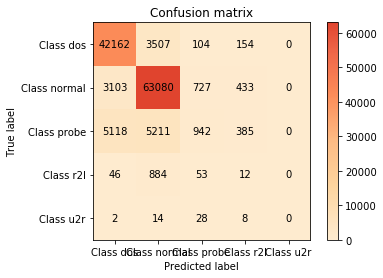

In [181]:
plot.confusion_matrix(data_final.iloc[:,-1], LR.predict(data_final.iloc[:,:-1]))

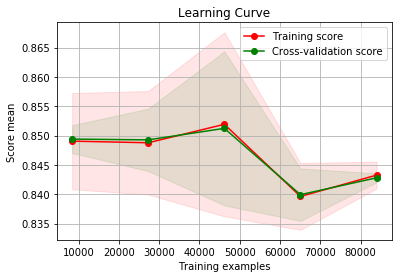

In [202]:
train_sizes, train_scores, test_scores = learning_curve(LR, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 overfitting 되었다.

## 3. Perceptron

In [754]:
Perceptron.fit(x_train,y_train)
Perceptron.score(x_test,y_test)

0.1191

### Prediction

In [57]:
sam= test_data_final.sample(1)
sam.xAttack

7939    dos
Name: xAttack, dtype: object

In [58]:
sam = sam.iloc[:,:-1]
Perceptron.predict(sam)

array(['dos'], 
      dtype='<U6')

#### Predicition success!!
### Graphs

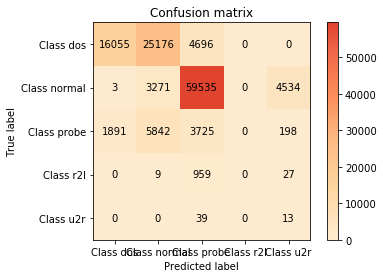

In [184]:
plot.confusion_matrix(data_final.iloc[:,-1], Perceptron.predict(data_final.iloc[:,:-1]))

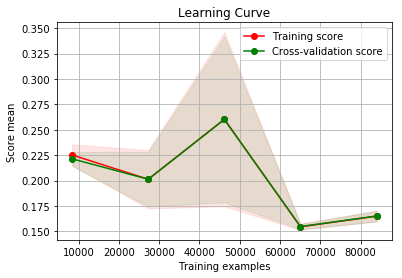

In [203]:
train_sizes, train_scores, test_scores = learning_curve(Perceptron, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 적절치 못한 모델임을 확인할 수 있었다.

## 4. MLP

In [770]:
MLP_classifier.fit(x_train,y_train)
MLP_classifier.score(x_test,y_test)

0.70979999999999999

### Prediciton

In [60]:
sam= test_data_final.sample(1)
sam.xAttack

2367    normal
Name: xAttack, dtype: object

In [61]:
sam = sam.iloc[:,:-1]
MLP_classifier.predict(sam)

array(['normal'], 
      dtype='<U6')

#### Prediction Success!!
### Graphs

C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


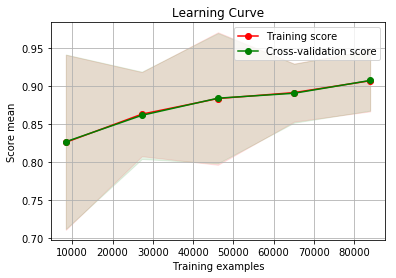

In [204]:
train_sizes, train_scores, test_scores = learning_curve(MLP_classifier, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 성능이 향상 되었으나 그 폭이 작았다.

## 5. KNN

In [771]:
KNN.fit(x_train,y_train)
KNN.score(x_test,y_test)

0.73540000000000005

### Prediction

In [65]:
sam= test_data_final.sample(1)
sam.xAttack


8314    normal
Name: xAttack, dtype: object

In [66]:
sam = sam.iloc[:,:-1]
KNN.predict(sam)

array(['normal'], dtype=object)

#### Prediction Success!!
### Graphs

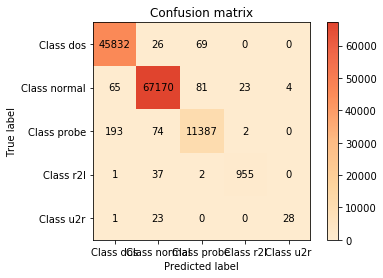

In [188]:
plot.confusion_matrix(data_final.iloc[:,-1], KNN.predict(data_final.iloc[:,:-1]))

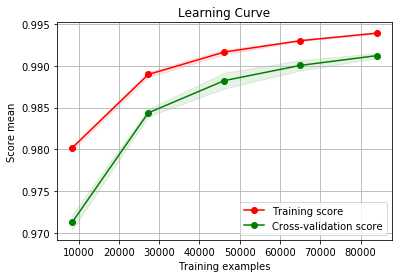

In [205]:
train_sizes, train_scores, test_scores = learning_curve(KNN, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 성능이 향상 되었다.

## 6. SVM

In [ ]:
data_sample=data_final.sample(10000)
x_sample = data_sample.iloc[:,:-1]
y_sample = data_sample.iloc[:,-1]
svm.fit(x_sample,y_sample)
svm.score(x_test,y_test)

## 7. Bagging

In [773]:
bagging.fit(x_train,y_train)
bagging.score(x_test,y_test)

0.76680000000000004

### Prediction

In [70]:
sam= test_data_final.sample(1)
sam.xAttack

6698    normal
Name: xAttack, dtype: object

In [71]:
sam = sam.iloc[:,:-1]
bagging.predict(sam)

array(['normal'], dtype=object)

#### Prediction Failed
### Graphs

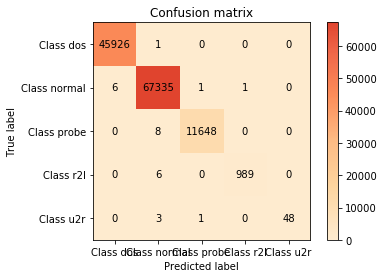

In [190]:
plot.confusion_matrix(data_final.iloc[:,-1], bagging.predict(data_final.iloc[:,:-1]))

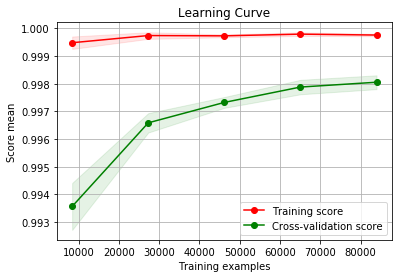

In [206]:
train_sizes, train_scores, test_scores = learning_curve(bagging, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 성능이 향상 되었다.

## 8. Adaboost

In [774]:
adaboost.fit(x_train,y_train)
adaboost.score(x_test,y_test)

0.65810000000000002

### Prediction

In [79]:
sam= test_data_final.sample(1)
sam.xAttack

852    dos
Name: xAttack, dtype: object

In [80]:
sam = sam.iloc[:,:-1]
adaboost.predict(sam)

array(['normal'], dtype=object)

#### Prediction Failed
### Graphs

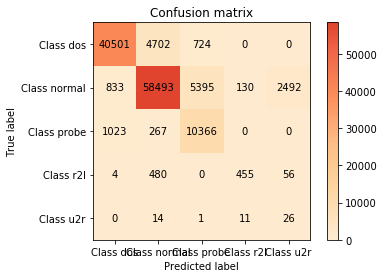

In [193]:
plot.confusion_matrix(data_final.iloc[:,-1], adaboost.predict(data_final.iloc[:,:-1]))

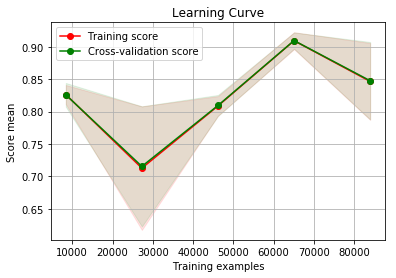

In [207]:
train_sizes, train_scores, test_scores = learning_curve(adaboost, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### training data가 많아 짐에 따라서 overfitting 되는 경향을 볼 수 있었다.

## 9. Random Forest

In [776]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.7702

### Prediction

In [82]:
sam= test_data_final.sample(1)
sam.xAttack

1583    normal
Name: xAttack, dtype: object

In [83]:
sam = sam.iloc[:,:-1]
decision_tree.predict(sam)

array(['normal'], dtype=object)

#### Prediction Success!!
### Graphs

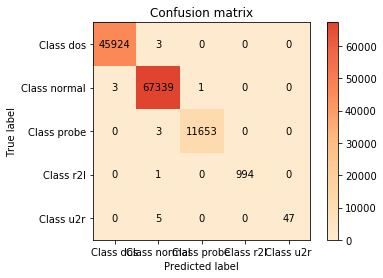

In [195]:
plot.confusion_matrix(data_final.iloc[:,-1], random_forest.predict(data_final.iloc[:,:-1]))

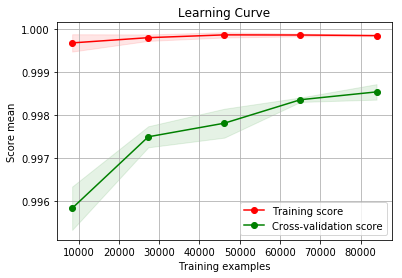

In [208]:
train_sizes, train_scores, test_scores = learning_curve(random_forest, x_train, y_train)
plot.learning_curve(train_scores, test_scores, train_sizes)

#### 전반적으로 training data가 많아 짐에 따라서 성능이 향상 되었다.

## 10. 결과 분석

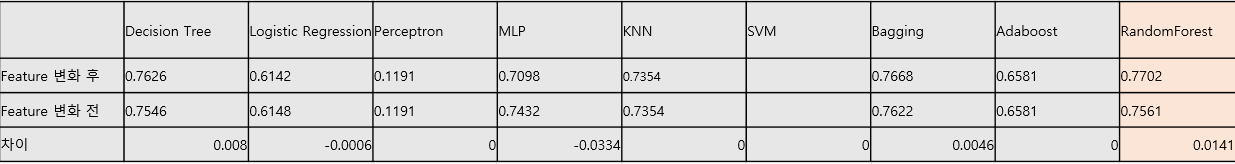

### 전반적으로 Feature에 변화를 주기 전 보다 성능이 향상 되었고, 
### 그 중에서 Random Forest가 가장 좋았으며, 성능도 가장 많이 향상되었다.
### 결과적으로 효과적으로 Feature에 준 것으로 판단할 수 있었다.

# Section 4. Model의 변화
#### 이번 section에서는 section 3에서 실행하였던 model 중, 가장 성능이 좋았던 Random Forest와 Bagging에 대해서 변화를 주어가면서 실험을 실행하여 최적의 모델을 찾고자 하였다.

## 1. Random Forest를 이용한 다양한 모델
### Random Forest에 대해서는 n_estimator, bootstrap, 그리고 criterion에 대해서 변화를 주면서 실험하였다.

### 1) n_estimator
#### n_estimator를 3, 5, 7, 10(default), 12, 15, 18, 20으로 변화해가면서 실험하였다.
#### 이 때에 bootstrap과 criterion을 default값이 False와 gini로 설정하였다.

In [68]:
random_forest2 = RandomForestClassifier(n_estimators=3,bootstrap=False,criterion='gini')
random_forest3 = RandomForestClassifier(n_estimators=5,bootstrap=False,criterion='gini')
random_forest4 = RandomForestClassifier(n_estimators=7,bootstrap=False,criterion='gini')
random_forest5 = RandomForestClassifier(n_estimators=12,bootstrap=False,criterion='gini')
random_forest6 = RandomForestClassifier(n_estimators=15,bootstrap=False,criterion='gini')
random_forest7 = RandomForestClassifier(n_estimators=18,bootstrap=False,criterion='gini')
random_forest8 = RandomForestClassifier(n_estimators=20,bootstrap=False,criterion='gini')

#### (1) n= 10 

In [816]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.76400000000000001

#### (2) n= 3 

In [817]:
random_forest2.fit(x_train,y_train)
random_forest2.score(x_test,y_test)

0.74670000000000003

#### (3) n= 5 

In [818]:
random_forest3.fit(x_train,y_train)
random_forest3.score(x_test,y_test)

0.75109999999999999

#### (4) n= 7 

In [819]:
random_forest4.fit(x_train,y_train)
random_forest4.score(x_test,y_test)

0.77149999999999996

#### (5) n= 12 

In [820]:
random_forest5.fit(x_train,y_train)
random_forest5.score(x_test,y_test)

0.75970000000000004

#### (6) n= 15 

In [821]:
random_forest6.fit(x_train,y_train)
random_forest6.score(x_test,y_test)

0.75970000000000004

#### (7) n= 18

In [822]:
random_forest7.fit(x_train,y_train)
random_forest7.score(x_test,y_test)

0.76190000000000002

#### (8) n= 20 

In [823]:
random_forest8.fit(x_train,y_train)
random_forest8.score(x_test,y_test)

0.74390000000000001

### 결과분석

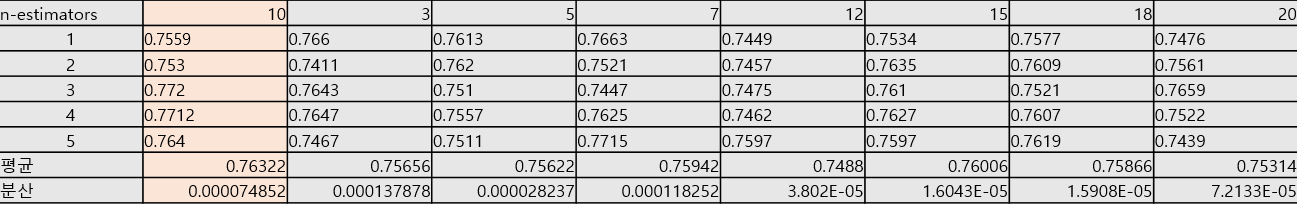
#### 다음과 같이 n_estimator = 10일 떄 가장 좋은 결과를 나타내었다.
#### n_estimator가 너무 적을 경우에는 voting을 하기에는 표본이 적어서 좋은 성능이 나타나지 않았고,
#### n_estimator가 너무 클 경우에는 Random Forest에서 적절하지 않은 attribute selection으로 부적절한 모델이 여럿 생성되기 때문이다.

### 2) Bootstrap
#### Bootstrap을 통하여 sample without replacement와 sample with replacement에 대해서 비교하였다.
#### Bootstrap을 사용할 경우에는 sample with replacement를 실행하는 것이다.
#### n_estimator과 criterion을 default값이 10과 gini를 사용하였다.

In [69]:
random_forest9 = RandomForestClassifier(n_estimators=10,bootstrap=True,criterion='gini')

#### (1) Bootstrap = False

In [833]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.75680000000000003

#### (2) Bootstrap = True

In [834]:
random_forest9.fit(x_train,y_train)
random_forest9.score(x_test,y_test)

0.75719999999999998

### 결과분석

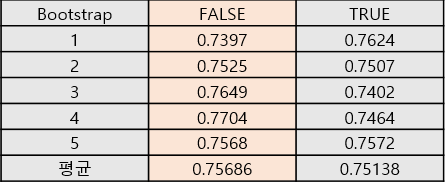
#### 5번의 iteration을 통하여 결과를 분석한 결과
### Bootstrap을 하지 않았을 때가 더 좋은 결과가 나타났다.
#### 그 이유는 Bootstrap은 data가 적을 경우에 효과적이고, sampling distribution을 파악하는 데에 효과적인데
#### 해당 data set에는 130000개 이상의 data가 존재하기 때문에 굳이 Bootstrap을 할 필요가 없기 때문이다.

### 3) Criterion
#### Tree를 만들기 위하여 그 criterion을 gini와 entropy로 바꾸어가며 실험하여 보았다.
#### n_estimator과 Bootstrap은 default값인 10과 False를 이용하였다.

In [70]:
random_forest10 = RandomForestClassifier(n_estimators=10,bootstrap=False,criterion='entropy')

#### (1) Gini

In [846]:
random_forest.fit(x_train,y_train)
random_forest.score(x_test,y_test)

0.76419999999999999

#### (2) Entropy

In [849]:
random_forest10.fit(x_train,y_train)
random_forest10.score(x_test,y_test)

0.74050000000000005

### 결과분석

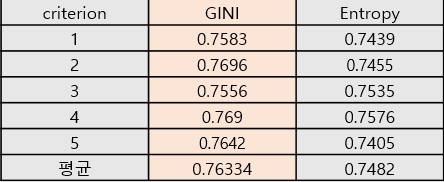
### Criterion을 GINI로 사용할 때가 더 성능이 좋았다.
#### Entropy보다 Gini가 해당 data set에서는 Attribute Selection에 더 적절한 것을 확인할 수 있었다.

## 2. Boosting을 이용한 다양한 모델
#### Boosting은 estimator의 변화, n_estimator의 변화를 주면서 실험을 진행하였다.
#### Estimator는 Decision Tree(default)와 Random Forest를 이용하였고, n_estimator는 3, 5, 10(default), 15 등으로 바꾸어주었다.

In [71]:
bagging2=BaggingClassifier(RandomForestClassifier(),n_estimators=3,n_jobs=-1)
bagging3=BaggingClassifier(RandomForestClassifier(),n_estimators=5,n_jobs=-1)
bagging4=BaggingClassifier(RandomForestClassifier(),n_estimators=10,n_jobs=-1)
bagging5=BaggingClassifier(RandomForestClassifier(),n_estimators=15,n_jobs=-1)
bagging6=BaggingClassifier(tree.DecisionTreeClassifier(),n_estimators=3,n_jobs=-1)
bagging7=BaggingClassifier(tree.DecisionTreeClassifier(),n_estimators=5,n_jobs=-1)
bagging8=BaggingClassifier(tree.DecisionTreeClassifier(),n_estimators=15,n_jobs=-1)

#### (1) estimator = decision tree, n_estimator = 10

In [873]:
bagging.fit(x_train,y_train)
bagging.score(x_test,y_test)

0.76359999999999995

#### (2) estimator = Random Forest, n_estimator = 3

In [874]:
bagging2.fit(x_train,y_train)
bagging2.score(x_test,y_test)

0.74119999999999997

#### (3) estimator = Random Forest, n_estimator = 5

In [875]:
bagging3.fit(x_train,y_train)
bagging3.score(x_test,y_test)

0.75660000000000005

#### (4) estimator = Random Forest, n_estimator = 10

In [876]:
bagging4.fit(x_train,y_train)
bagging4.score(x_test,y_test)

0.75229999999999997

#### (5) estimator = Random Forest, n_estimator = 15

In [877]:
bagging5.fit(x_train,y_train)
bagging5.score(x_test,y_test)

0.74590000000000001

#### (6) estimator = decision tree, n_estimator = 3

In [878]:
bagging6.fit(x_train,y_train)
bagging6.score(x_test,y_test)

0.76160000000000005

#### (7) estimator = decision tree, n_estimator = 5

In [879]:
bagging7.fit(x_train,y_train)
bagging7.score(x_test,y_test)

0.7571

#### (8) estimator = decision tree, n_estimator = 15

In [880]:
bagging8.fit(x_train,y_train)
bagging8.score(x_test,y_test)

0.76439999999999997

### 결과분석

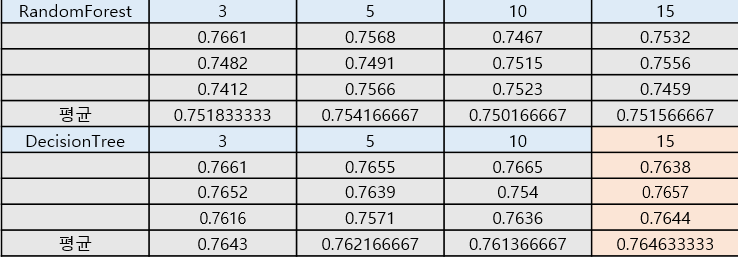
### Decision Tree with n_estimators = 15일 때 가장 성능이 좋았다. 
#### 하지만 RandomForest에는 성능이 미치지 못하였다.
#### 일반적으로 estimator를 Decision tree를 사용할 때가 Random Forest보다 다소 성능이 뛰어 났는데 Random Forest를 사용하면 Complextity가 많이 커지기 때문이라고 생각된다.

## 3. MLP를 이용한 다양한 모델
#### MLP와 같은 경우에는 데이터의 크기를 최대한 비슷하게 맞추어 주었다. 즉, 모든 feature를 normalization해 주었다.
#### MLP의 경우에 기존의 Hidden Layer와 Node를 더 많이 사용하였고, activation fuction, learning rate를 달리하면서 실험하였다.
#### 그리고 overfitting을 방지하기 위해서 early_stopping을 조작하였다.

## Feature Selection 및 Normalization

In [172]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)

test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)

data_weka.iloc[:,:-1]=(data_weka.iloc[:,:-1]-data_weka.iloc[:,:-1].min())/(data_weka.iloc[:,:-1].max()-data_weka.iloc[:,:-1].min())
test_data_weka.iloc[:,:-1]=(test_data_weka.iloc[:,:-1]-test_data_weka.iloc[:,:-1].min())/(test_data_weka.iloc[:,:-1].max()-test_data_weka.iloc[:,:-1].min())

data_final=data_weka
test_data_final = test_data_weka

x_train =(data_final.iloc[:,:-1])
y_train=(data_final.iloc[:,-1])
x_test =(test_data_final.iloc[:,:-1])
y_test=(test_data_final.iloc[:,-1])

## 1) Function의 변화
### (1) activation = tanh, learning_rate = adaptive

In [112]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,10), max_iter=200, warm_start=False, activation='tanh',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76480000000000004

### (2) activation = relu, learning_rate = adaptive

In [113]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.77439999999999998

### (3) activation = tanh, learning_rate = constant

In [114]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,10), max_iter=200, warm_start=False, activation='tanh',early_stopping=True,learning_rate='constant')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76149999999999995

### (4) activation = relu, learning_rate = constant

In [115]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='constant')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76900000000000002

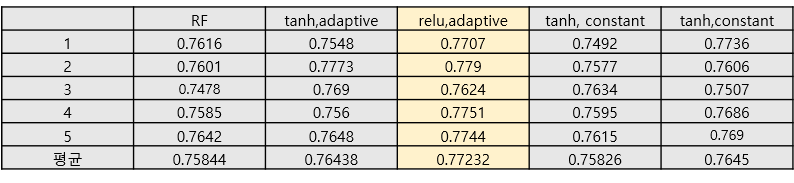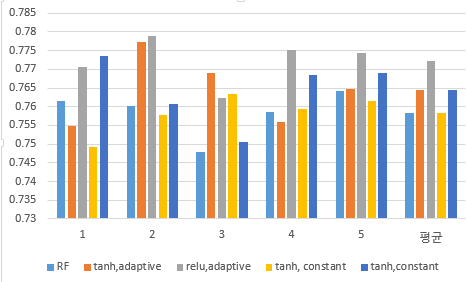
#### 다음 표, 그래프에서 볼 수 있다시피 activation fuction으로 relu를 사용하고 learning_rate를 adaptive하게 하였을 때 가장 좋은 성능을 보였다.

## 2) Layer의 변화

### (1) hidden_layer_sizes=(50,5)

In [152]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(50,5), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76670000000000005

### (2) hidden_layer_sizes=(50,10)

In [153]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.75439999999999996

### (3) hidden_layer_sizes=(50,20)

In [154]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(50,20), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.75390000000000001

### (4) hidden_layer_sizes=(100,5)

In [155]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,5), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.75680000000000003

### (5) hidden_layer_sizes=(100,10)

In [156]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76590000000000003

### (6) hidden_layer_sizes=(100,20)

In [157]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,20), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76190000000000002

### (7) hidden_layer_sizes=(200,5)

In [158]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(200,5), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.74919999999999998

### (8) hidden_layer_sizes=(200,10)

In [159]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(200,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.76649999999999996

### (9) hidden_layer_sizes=(200,20)

In [160]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(200,20), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.74870000000000003

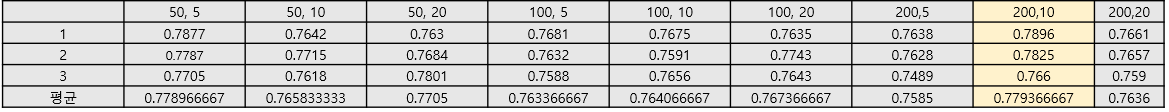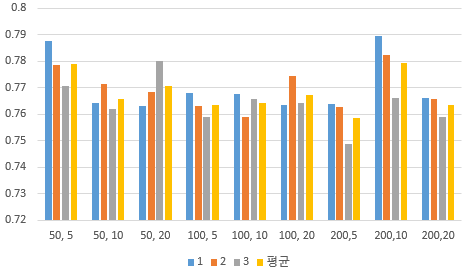
#### 3번의 iteration을 통하여 Hidden Layer Size = (200,10)일 때 , 일반적으로 가장 좋은 성능을 보이는 것을 볼 수 있었다.
#### Hidden Layer가 많을 수록 많은 Data를 잘 학습할 수 있기 때문인 것으로 파악된다.

# Section 5. 결론

#### 125973 rows × 42 columns 개의 Data를 이용하여 다양한 모델에 대한 기계학습을 진행하였다.
#### 주어진 feature들을 가지고 Network Security 침입 유형을 classify하는 것이다.
#### 가장 먼저 Categorial Feature를 one hot encoding하여 numerical feature로 바꾸어서 Decision tree, logistic regression, perceptron, MLP, SVM, KNN, Bagging, Adaboost, Random Forest 모델에 대해서 학습을 진행하였다.(SVM과 같은 경우에는 시간이 부족하여 학습시키는데에 실패하였다.) 
#### Cross-validation과 주어진 test data로 평가한  결과, Random forest가 가장 좋은 성능을 보이는 것을 확인하였다.
#### 그 후, 각 Feature에게 변화를 주었다. 직관적으로 feature를 제거하기도 하고, normalization이 필요할 것으로 예상되는 feature들에 대해서는 normalization을 실행하였다.
#### Feature의 변화 후, 기본적인 model에 대한 학습과 model에 변화를 준 학습을 모두 진행하였다.
#### 그 결과, 가장 성능이 좋은 모델은 Random Forest(option = default)였다. Random Forest를 이용하여 73~77%의 정확도를 가지도록 하는데에 성공하였으나,
#### MLP는 최근 딥러닝의 기본이 되는 모델이기 때문에 좋은 성능을 나타낼 여지가 충분이 있다고 생각되어 MLP에 관련한 실험을 진행하였다. 
#### MLP에서 사용되는 여러가지 함수의 종류를 바꾸어보고, Hidden layer를 바꾼 결과 조금이나마 성능이 향상된 결과를 볼 수 있었다.
#### 정확도가 74~80%정도로 다양하게 나타났는데 그 이유는 test set이 Random하게 바뀌었기 때문이다.
## 결과적으로 총 20여가지의 모델 중에서 
## MLP(Hidden Layer = (200, 10), activation_fuction = Relu, learning_rate = adaptive)가 
## 가장 뛰어난 성능을 보였다.
#### 만약 조금의 시간이 더 존재한다면, num_failed_login과 같이 크기가 중요하지 않은 feature들에 대하여 one hot encoding을 하는 등의 방법을 통해서 더 정확도를 올릴 수 있었을 것이다.

# 최종 모델

# Protocol_type에 대한 One-hot coding이 필요합니다.

In [335]:
data_weka=data_onehot.drop('urgent',axis=1)
data_weka=data_weka.drop('is_host_login',axis=1)
data_weka=data_weka.drop('num_shells',axis=1)
data_weka=data_weka.drop('num_outbound_cmds',axis=1)

test_data_weka=test_data_onehot.drop('urgent',axis=1)
test_data_weka=test_data_weka.drop('is_host_login',axis=1)
test_data_weka=test_data_weka.drop('num_shells',axis=1)
test_data_weka=test_data_weka.drop('num_outbound_cmds',axis=1)

data_weka.iloc[:,:-1]=(data_weka.iloc[:,:-1]-data_weka.iloc[:,:-1].min())/(data_weka.iloc[:,:-1].max()-data_weka.iloc[:,:-1].min())
test_data_weka.iloc[:,:-1]=(test_data_weka.iloc[:,:-1]-test_data_weka.iloc[:,:-1].min())/(test_data_weka.iloc[:,:-1].max()-test_data_weka.iloc[:,:-1].min())

data_final=data_weka
test_data_final = test_data_weka

x_train =(data_final.iloc[:,:-1])
y_train=(data_final.iloc[:,-1])
x_test =(test_data_final.iloc[:,:-1])
y_test=(test_data_final.iloc[:,-1])

In [334]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(200,10), max_iter=200, warm_start=False, activation='relu',early_stopping=True,learning_rate='adaptive')
MLP_classifier.fit(x_train, y_train)
MLP_classifier.score(x_test, y_test)

0.79390000000000005

# 최종 정확도 : 79.39% !!